In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

## Importing and Understanding Data

1. Load the data
2. Check if weekday column is properly populated
3. Drop the unique columns

In [347]:
# Load the csv
df= pd.read_csv('day.csv')

In [348]:
# Data of two years (365days of 2018 +365 days of 2019)
df.shape

(730, 16)

In [349]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [350]:
# Convert the dteday to date type
df.dteday=df.dteday.apply(lambda x : datetime.strptime(x, '%d-%m-%Y'))

In [351]:
# Check whether the day extracted from dteday is same as weekday
df['check_weekday']=df.dteday.apply(lambda x :  x.strftime('%a'))
df['check_weekday']=df['check_weekday'].map({"Tue": 0,'Wed': 1 , 'Thu': 2,'Fri':3, 'Sat': 4,'Sun':5,'Mon':6})

In [352]:
# Not proper data from 2019-03-01 . Dropping weekday 
df[df['weekday']!=df['check_weekday']][['dteday','check_weekday','weekday']]

,dteday,check_weekday,weekday
424,2019-03-01,3,4
425,2019-03-02,4,5
426,2019-03-03,5,6
427,2019-03-04,6,0
428,2019-03-05,0,1
...,...,...,...
725,2019-12-27,3,4
726,2019-12-28,4,5
727,2019-12-29,5,6
728,2019-12-30,6,0


In [353]:
# looks like day is wrongly recoreded from March 1st 2019
df.loc[[423,424],['dteday','weekday','check_weekday']]

,dteday,weekday,check_weekday
423,2019-02-28,2,2
424,2019-03-01,4,3


In [354]:
# updating weekday with the day extracted from date
df['weekday']=df['check_weekday']

In [355]:
# Dropping the not check_weekday as it is duplicate of weekday
df=df.drop(columns=['check_weekday'])

In [356]:
# Dropping the columns as they are unique
df.drop(columns=['dteday','instant'], inplace=True)

In [357]:
# dropping casual,registered as we are we not concerned about it and only about total cnt
df.drop(columns=['casual','registered'], inplace=True)

In [358]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'],
      dtype='object')

# Methods used

In [359]:
# Method returns the values of the lower whisker and upper whisker of the boxplot
def getBoundaries(df,column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5*IQR
    upper_whisker = Q3 + 1.5*IQR
    return lower_whisker,upper_whisker 

In [360]:
#To bin the feature based on given step size
def bin_feature(feature, no_of_bins):
    lower = feature.min()
    higher = feature.max()
    bins = np.arange(lower, higher+1, (higher - lower)/no_of_bins)
    labels = ['-'.join(map(str,(round(x,2),round(y,2)))) for x, y in zip(bins[:-1], bins[1:])]
    return pd.cut(feature, bins, labels=labels)

In [361]:
# create dummy variables for categorical variables
def createDummies(col,df):
    status = pd.get_dummies(df[col],prefix=col)
    df = pd.concat([df, status], axis = 1)
    df.drop([col], axis = 1, inplace = True)
    return df

In [362]:
# prints the vif of all the columns
def printVIF(col , X_train):
    vif = pd.DataFrame()
    vif['Features'] = col
    vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    print(vif)

# Visualising the data

## Univariate analysis

1. To identify the outliers in continous variables(temp, atemp, hum, windspeed , cnt) and remove them. 

<AxesSubplot:xlabel='temp'>

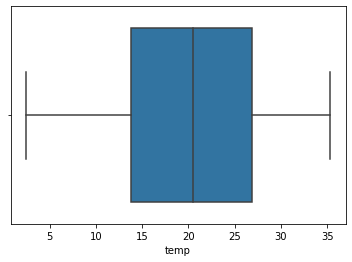

In [363]:
#check outliers for temp
sns.boxplot(df.temp)

<AxesSubplot:xlabel='atemp'>

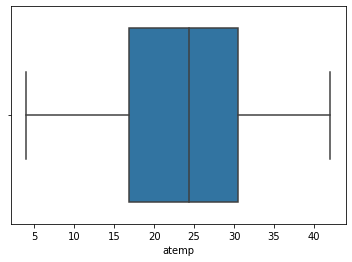

In [364]:
#check outliers for atemp
sns.boxplot(df.atemp)

<AxesSubplot:xlabel='hum'>

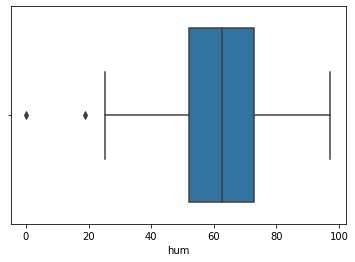

In [365]:
#check outliers for hum
sns.boxplot(df.hum)

In [366]:
# Looks like there are outliers in humidity . Removing them
lower_whisker, upper_whisker= getBoundaries(df,'hum')
df= df[(df.hum>=lower_whisker) &(df.hum<=upper_whisker)]

<AxesSubplot:xlabel='hum'>

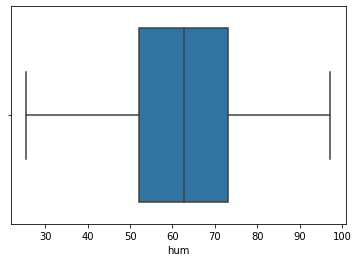

In [367]:
#Check if there are any outliers now for hum
sns.boxplot(df.hum)

In [368]:
df.shape

(728, 12)

<AxesSubplot:xlabel='windspeed'>

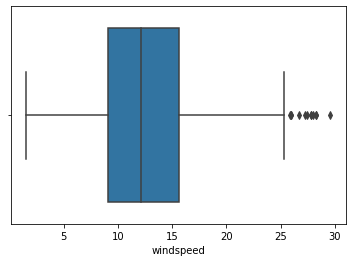

In [369]:
#check outliers for windspeed
sns.boxplot(df.windspeed)

In [370]:
# Looks like there are outliers in windspeed . Removing them
lower_whisker, upper_whisker= getBoundaries(df,'windspeed')
df=df[(df.windspeed>=lower_whisker) &(df.windspeed<=upper_whisker)]

In [371]:
df.shape

(716, 12)

<AxesSubplot:xlabel='cnt'>

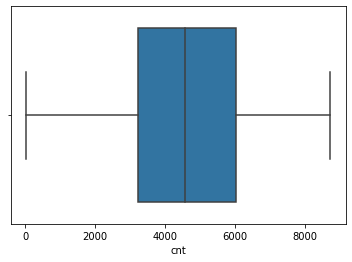

In [372]:
#check outliers for cnt
sns.boxplot(df.cnt)

<AxesSubplot:>

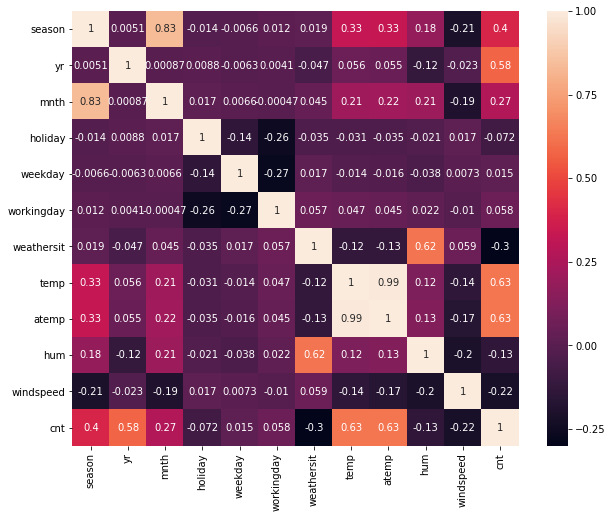

In [373]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True)

# Bivariate Analysis

1. As we are going to build model to predict cnt based on other variables , we need to check if there are outliers with respect to the category in cnt and remove them.
2. Also, identify if any of the attributes are corrleated

<AxesSubplot:xlabel='season', ylabel='cnt'>

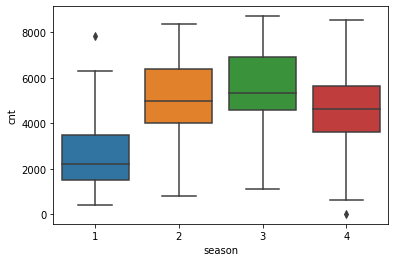

In [374]:
# Check outlier for cnt with respect to each season
sns.boxplot(x= df.season , y=df.cnt)

#### Season  spring, winter has less cnt compared to summer and fall 

Looks like there are outliers in season 1 and season 4 for cnt column

In [375]:
# get boundaries of cnt for season 1
lower_whisker, upper_whisker= getBoundaries(df[df['season']==1],'cnt')

In [376]:
# remove outliers from season 1
df= df[((df['season']==1) & (df.cnt <=upper_whisker) & (df.cnt >=lower_whisker)) |(df['season']!=1) ]

<AxesSubplot:xlabel='season', ylabel='cnt'>

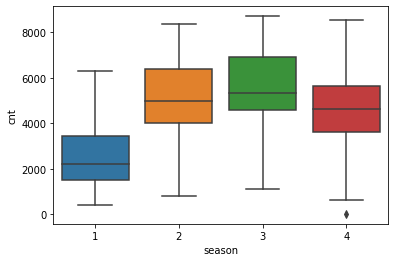

In [377]:
# Check outlier for cnt with respect to each season again
sns.boxplot(x= df.season , y=df.cnt)

In [378]:
# get boundaries of cnt for season 4
lower_whisker, upper_whisker= getBoundaries(df[df['season']==4],'cnt')

In [379]:
# remove outliers from season 4
df= df[((df['season']==4) & (df.cnt <=upper_whisker) & (df.cnt >=lower_whisker)) |(df['season']!=4) ]

<AxesSubplot:xlabel='season', ylabel='cnt'>

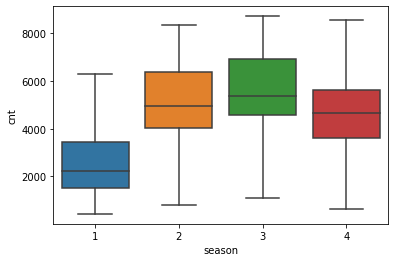

In [380]:
# Check outlier for cnt with respect to each season again
sns.boxplot(x= df.season , y=df.cnt)

<AxesSubplot:xlabel='yr', ylabel='cnt'>

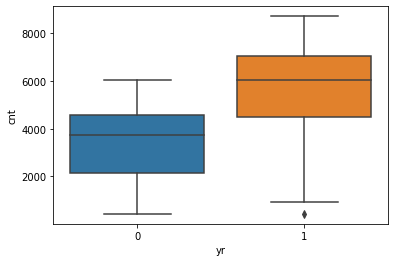

In [381]:
# Check outlier for cnt with respect to each year
sns.boxplot(x= df.yr , y=df.cnt)

#### 2019 year has more cnt compared to 2018 year.

In [382]:
# get boundaries of cnt for yr having value 1
lower_whisker, upper_whisker= getBoundaries(df[df['yr']==1],'cnt')

In [383]:
# remove outliers from yr
df= df[((df['yr']==1) & (df.cnt <=upper_whisker) & (df.cnt >=lower_whisker)) |(df['yr']!=1) ]

<AxesSubplot:xlabel='yr', ylabel='cnt'>

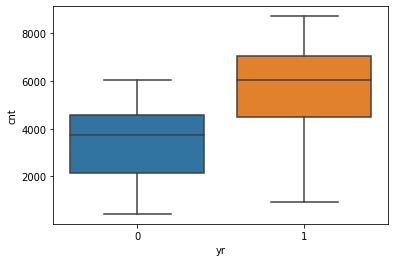

In [384]:
# Check outlier for cnt with respect to each year
sns.boxplot(x= df.yr , y=df.cnt)

<AxesSubplot:xlabel='mnth', ylabel='cnt'>

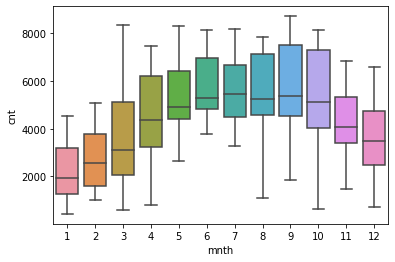

In [385]:
# Check outlier for cnt with respect to each month
sns.boxplot(x= df.mnth , y=df.cnt)

#### Pattern seen among months is almost inconsistent with season.

<AxesSubplot:xlabel='holiday', ylabel='cnt'>

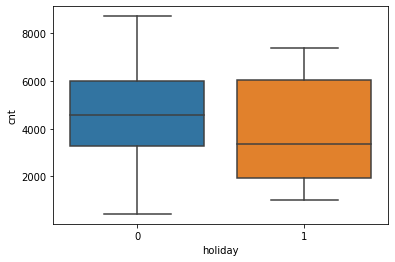

In [386]:
# Check outlier for cnt with respect to holiday 
sns.boxplot(x= df.holiday , y=df.cnt)

#### Bikes are used more on workingdays compared to holiday

<AxesSubplot:xlabel='weekday', ylabel='cnt'>

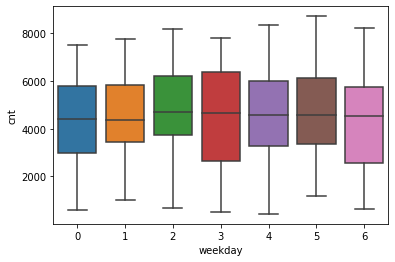

In [387]:
# Check outlier for cnt with respect to weekday 
sns.boxplot(x= df.weekday , y=df.cnt)

#### Almost all days have same cnt , so droping the day

In [388]:
df.drop(['weekday'], axis = 1, inplace = True)

<AxesSubplot:xlabel='workingday', ylabel='cnt'>

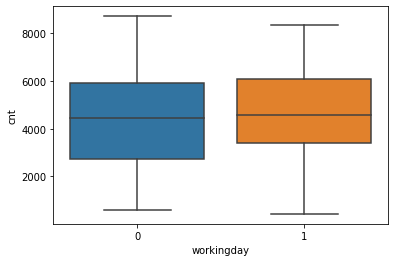

In [389]:
# Check outlier for cnt with respect to workingday 
sns.boxplot(x= df.workingday , y=df.cnt)

#### No visible pattern seen for workingday

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

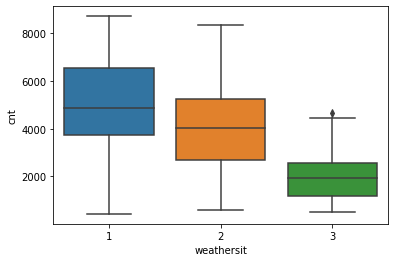

In [390]:
# Check outlier for cnt with respect to weathersit 
sns.boxplot(x= df.weathersit , y=df.cnt)

#### cnt is very low for weathersit 3 compared to 1 and 2 

In [391]:
#remove outlier for cnt with respect to weathersit 3
lower_whisker, upper_whisker= getBoundaries(df[df['weathersit']==3],'cnt')
df= df[~((df['weathersit']==3) & (df.cnt > upper_whisker))]

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

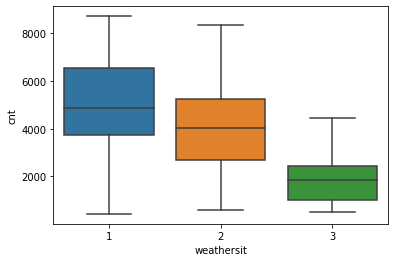

In [392]:
# Check outlier for cnt with respect to weathersit  again
sns.boxplot(x= df.weathersit , y=df.cnt)

<AxesSubplot:xlabel='temp', ylabel='cnt'>

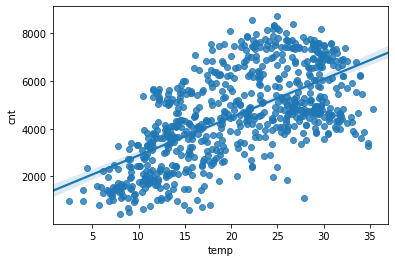

In [393]:
# Check if linearly related to cnt
sns.regplot(x= df.temp , y=df.cnt)

#### cnt has increased wth temp till 30 but there is reduce in cnt after 30(indicating curvlinear relationship) . 
#### As there is no linear relationship , we would be binning the temp and use them later


In [394]:
# Creating 6 bins for temp
df['temp_bin'] = bin_feature(df['temp'], 6)

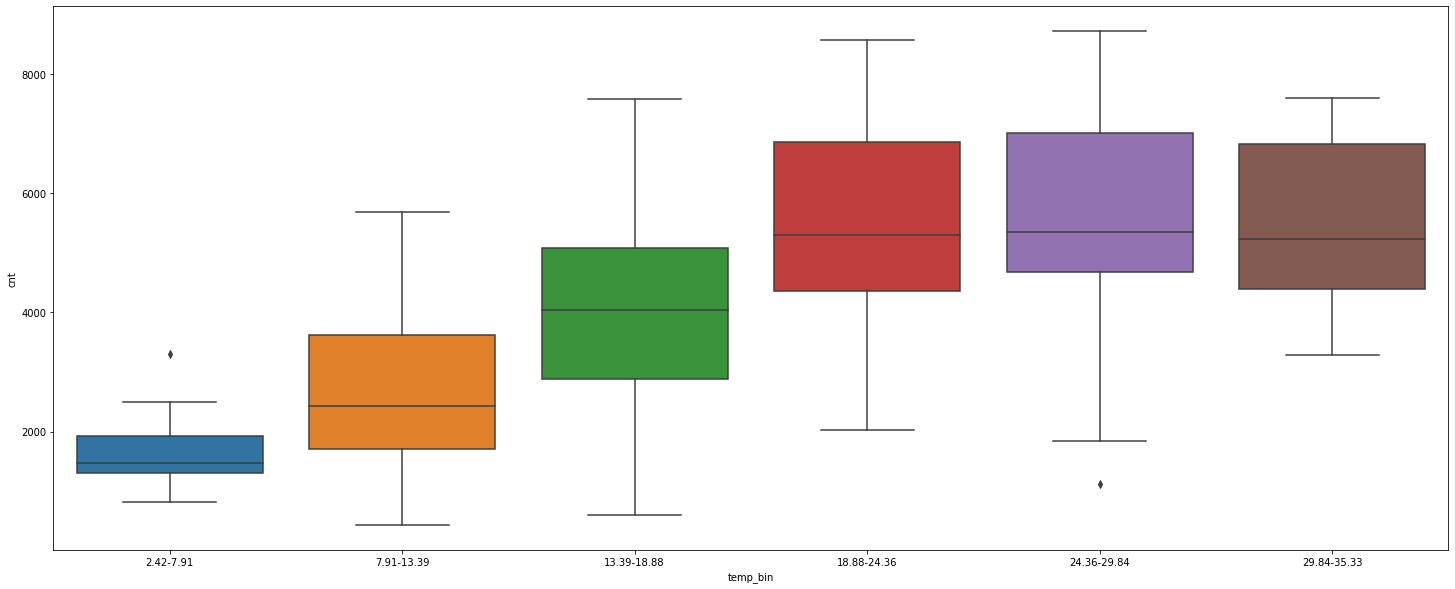

In [395]:
#check if there are outliers in cnt for temp bins
plt.figure(figsize=[25,10])
sns.boxplot(x=df['temp_bin'], y= df.cnt)
plt.show() 

#### Looks like there are outliers for temp bins 1s and 5th

In [396]:
#remove outliers in cnt for temp bins
lower_whisker, upper_whisker= getBoundaries(df[df['temp_bin']=='2.42-7.91'],'cnt')
df= df[((df['temp_bin']=='2.42-7.91') & (df.cnt <=upper_whisker )) |(df['temp_bin']!='2.42-7.91') ]

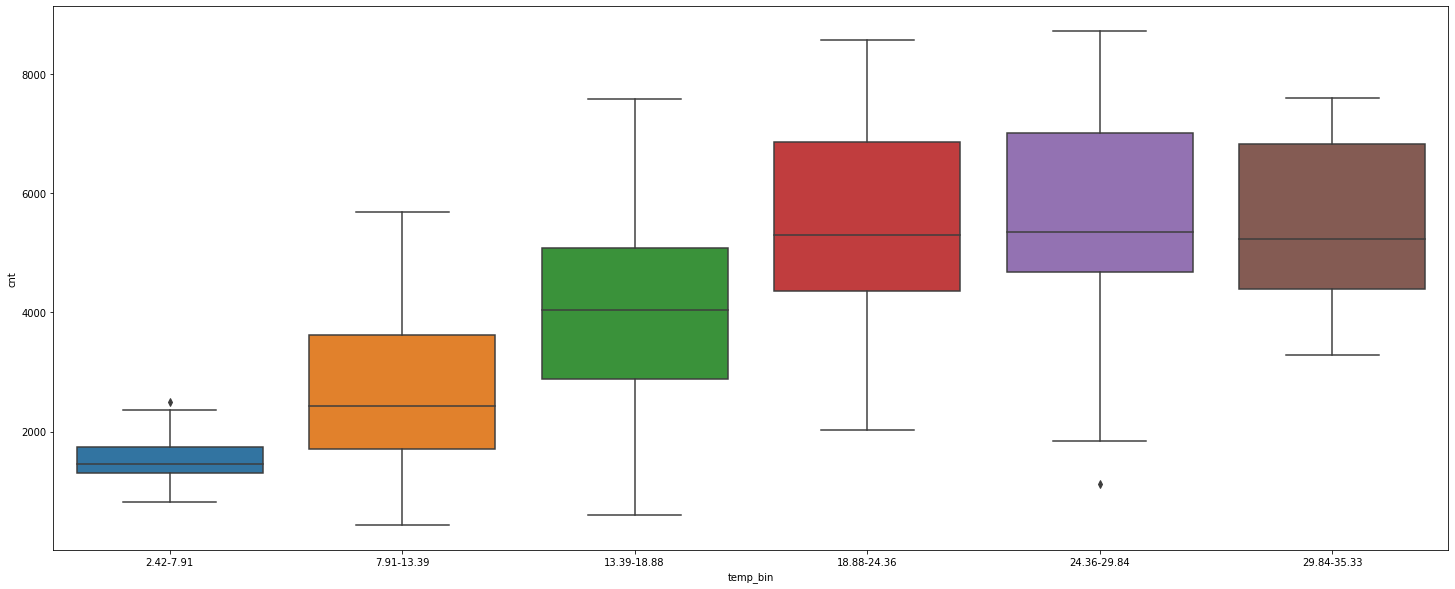

In [397]:
#check if there are outliers in cnt for temp bins again
plt.figure(figsize=[25,10])
sns.boxplot(x=df['temp_bin'], y= df.cnt)
plt.show()

In [398]:
#remove outliers in cnt for temp bins
lower_whisker, upper_whisker= getBoundaries(df[df['temp_bin']=='2.42-7.91'],'cnt')
df= df[((df['temp_bin']=='2.42-7.91') & (df.cnt <=upper_whisker )) |(df['temp_bin']!='2.42-7.91') ]

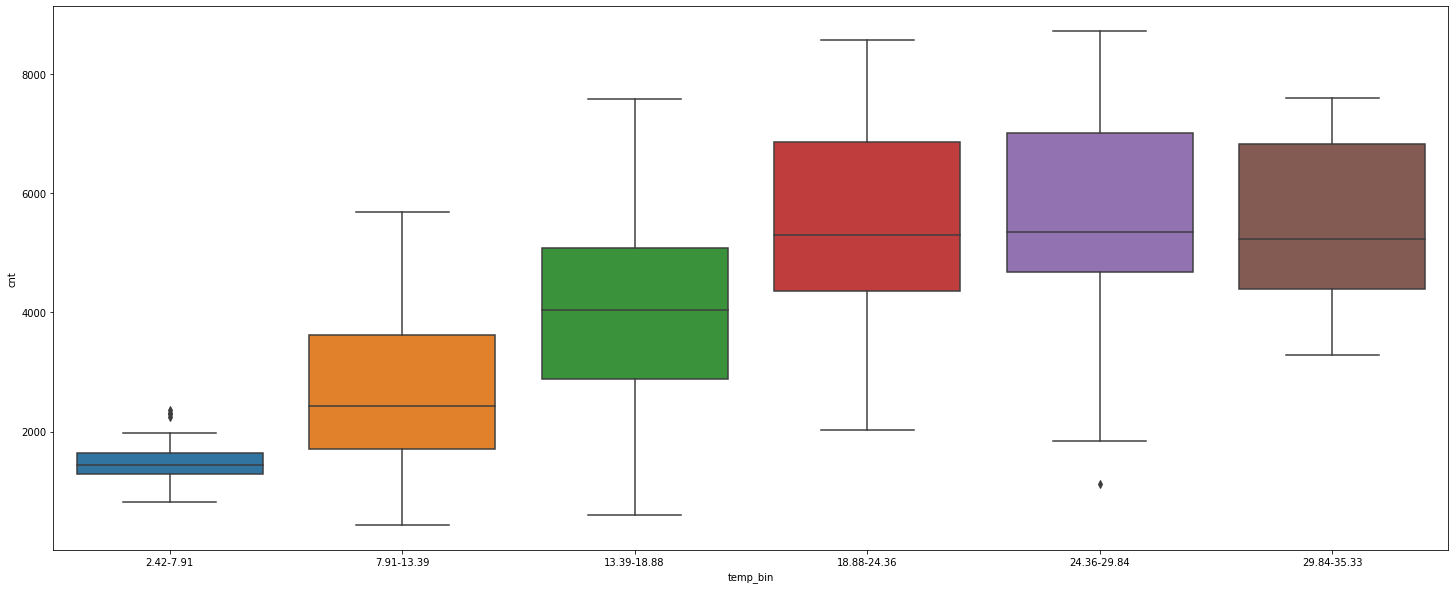

In [399]:
#check if there are outliers in cnt for temp bins again
plt.figure(figsize=[25,10])
sns.boxplot(x=df['temp_bin'], y= df.cnt)
plt.show() 

In [400]:
#remove outliers in cnt for temp bins
lower_whisker, upper_whisker= getBoundaries(df[df['temp_bin']=='2.42-7.91'],'cnt')
df= df[((df['temp_bin']=='2.42-7.91') & (df.cnt <=upper_whisker )) |(df['temp_bin']!='2.42-7.91') ]

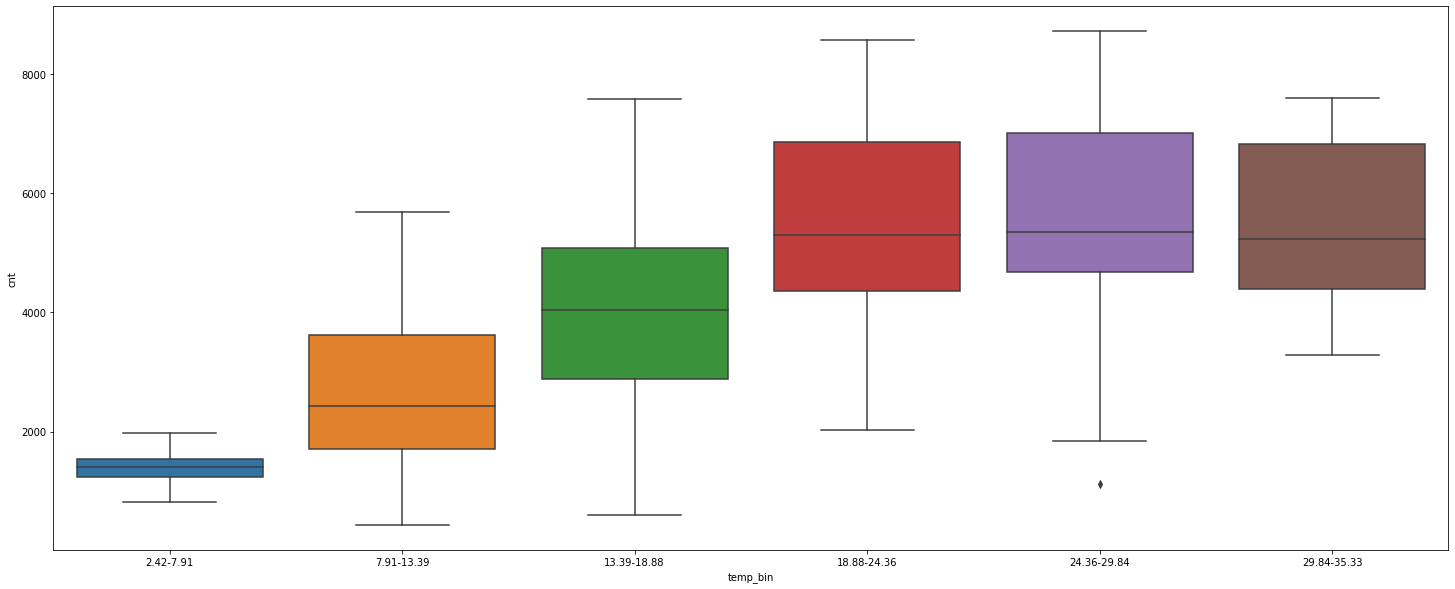

In [401]:
#check if there are outliers in cnt for temp bins again
plt.figure(figsize=[25,10])
sns.boxplot(x=df['temp_bin'], y= df.cnt)
plt.show()

In [402]:
#remove outliers in cnt for temp bins
lower_whisker, upper_whisker= getBoundaries(df[df['temp_bin']=='24.36-29.84'],'cnt')

In [403]:
df= df[((df['temp_bin']=='24.36-29.84') & (df.cnt >=lower_whisker )) |(df['temp_bin']!='24.36-29.84') ]

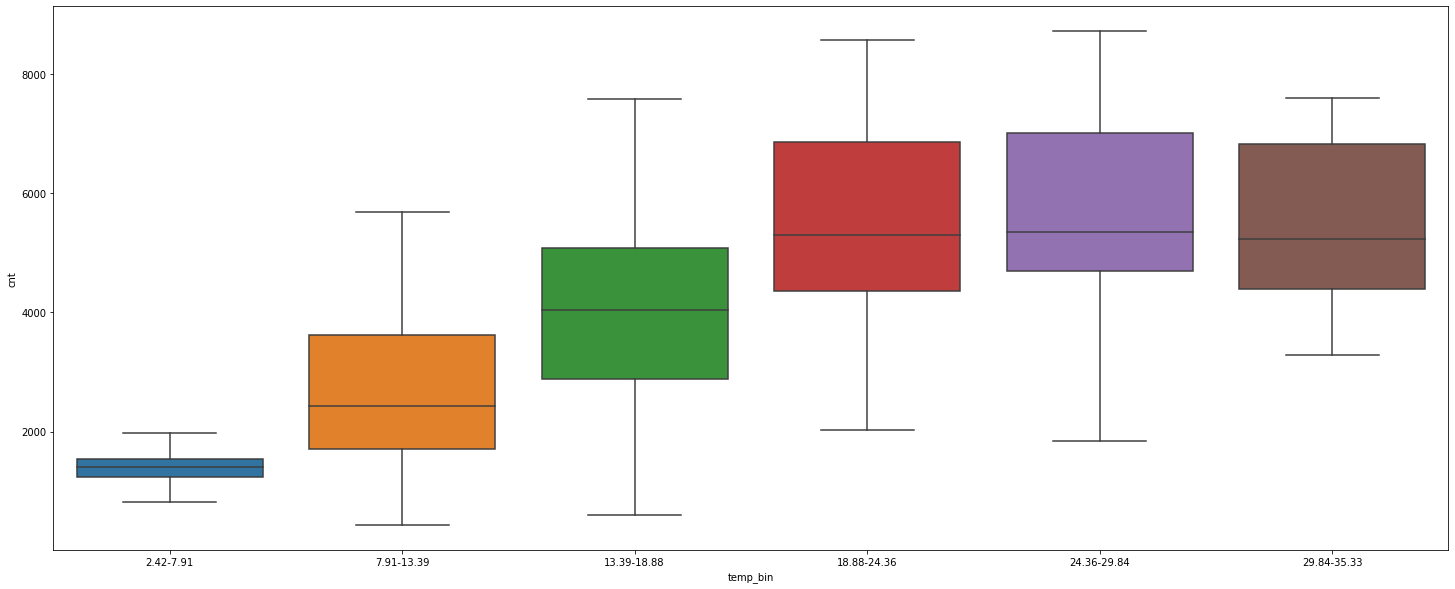

In [404]:
#check if there are outliers in cnt for temp bins again
plt.figure(figsize=[25,10])
sns.boxplot(x=df['temp_bin'], y= df.cnt)
plt.show()

In [405]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit', 'temp',
       'atemp', 'hum', 'windspeed', 'cnt', 'temp_bin'],
      dtype='object')

<AxesSubplot:xlabel='temp', ylabel='atemp'>

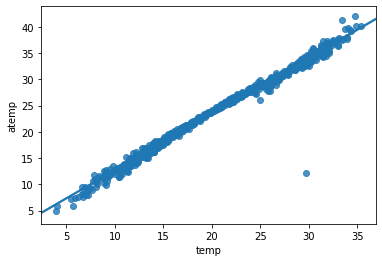

In [406]:
#Check if temp and atemp are corelated
sns.regplot(x= df.temp, y= df.atemp)

<AxesSubplot:>

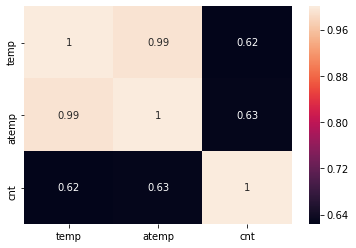

In [407]:
# Plot heatmap for these three variables
sns.heatmap(df[['temp','atemp','cnt']].corr(), annot=True)

#### Temp is correlated with atemp , considering temp instead of atemp.

In [408]:
#AS we have created bins for temperature , dropping temp also
df.drop(['temp', 'atemp'], axis = 1, inplace = True)

<AxesSubplot:xlabel='windspeed', ylabel='cnt'>

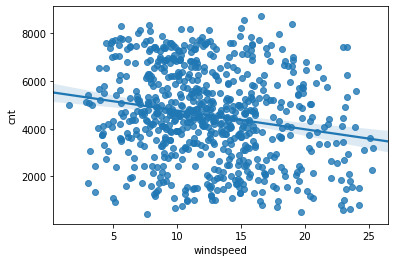

In [409]:
# no pattern seen
sns.regplot(x= df.windspeed , y=df.cnt)

<AxesSubplot:xlabel='hum', ylabel='cnt'>

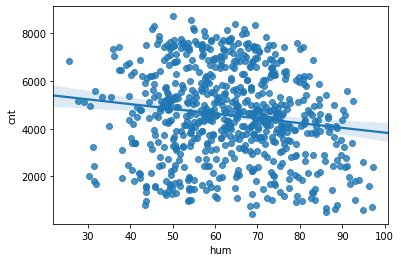

In [410]:
# cnt is less for higher humidity , so binning the humidity
sns.regplot(x= df.hum , y=df.cnt)

In [411]:
# Creating 4 bins for humidity
df['hum_bin'] = bin_feature(df['hum'],4)

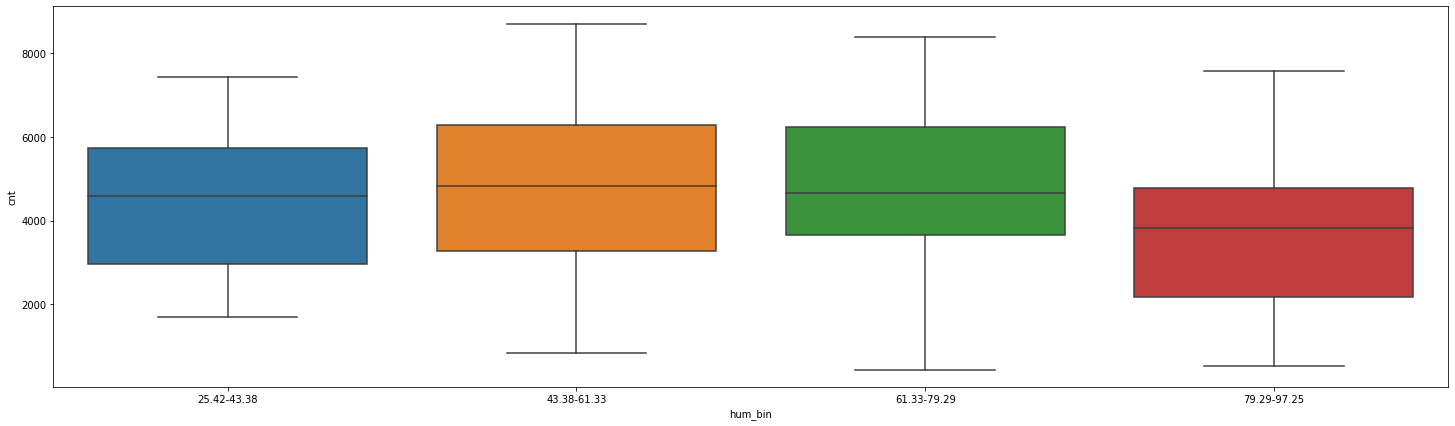

In [412]:
#Check if there are outliers in cnt for humidity
plt.figure(figsize=[25,7])
sns.boxplot(x=df['hum_bin'], y= df.cnt)
plt.show() 

#### cnt for 4th humidity bin is less ,indicating strong relationship with cnt

In [413]:
# Dropping humidity aswe have created bins
df.drop(['hum'], axis = 1, inplace = True)

In [414]:
df.columns

Index(['season', 'yr', 'mnth', 'holiday', 'workingday', 'weathersit',
       'windspeed', 'cnt', 'temp_bin', 'hum_bin'],
      dtype='object')

In [415]:
df.shape

(704, 10)

### Conclusion from univerate and bivariate analysis
1. Spring season has less count of bookings compared to other seasons.
2. Number of bookings got increased in 2019.
3. Bikes are used more on working days compared to holiday
4. No pattern seen among the spread around weekdays.
5. No pattern seen for working day.
5. Weathersit light snow has very less cnt compared to weathersit mist and weathersit clear. 
6. cnt has increased with raise in temperature till 30 but there is reduce in cnt after 30(indicating curvlinear relationship) . As there is no linear relationship, considered the variable as categorical variables and created 6 bins out of the temp. Clear pattern is visible among temperature bins for cnt.
7. Cnt has reduced when humidity is greater 80 . As there is no pattern visible for humidity range 30-80 ,created bins for humidity as well.
8. Atemp is highly correlated with temp . Hence dropped the attribute to avoid multi collinearity.
9. Windspeed has no impact on cnt

### Features effecting cnt would be :
1. Year 2019 
2. temperature bins 
3.  weathersit 
4. season
5. 

## Data Preparation

##### Columns like weathersit, season ,temp_bin, hum_bin are categorical variables.
##### We need to create dummy variables for these columns to create model of it

In [416]:
#Map season number with actual season
df['season'] = df['season'].map({1: 'spring',2:'summer',3:'fall',4 :'winter'})

In [417]:
#create dummy variables for season and drop season
df=createDummies('season',df)

In [418]:
df.head()

,yr,mnth,holiday,workingday,weathersit,windspeed,cnt,temp_bin,hum_bin,season_fall,season_spring,season_summer,season_winter
0,0,1,0,0,2,10.749882,985,13.39-18.88,79.29-97.25,0,1,0,0
1,0,1,0,0,2,16.652113,801,13.39-18.88,61.33-79.29,0,1,0,0
2,0,1,0,1,1,16.636703,1349,7.91-13.39,43.38-61.33,0,1,0,0
3,0,1,0,1,1,10.739832,1562,7.91-13.39,43.38-61.33,0,1,0,0
4,0,1,0,1,1,12.522300,1600,7.91-13.39,43.38-61.33,0,1,0,0


In [419]:
# Rename variable to 2019
df=df.rename(columns={'yr' :'yr2019'})

In [420]:
#Map weathersit numbers with actual weathersit  and create dummy columns
df['weathersit'] = df['weathersit'].map({1: 'clear',2:'Mist',3:'Light Snow'})
df=createDummies('weathersit',df)

In [421]:
df.columns

Index(['yr2019', 'mnth', 'holiday', 'workingday', 'windspeed', 'cnt',
       'temp_bin', 'hum_bin', 'season_fall', 'season_spring', 'season_summer',
       'season_winter', 'weathersit_Light Snow', 'weathersit_Mist',
       'weathersit_clear'],
      dtype='object')

In [422]:
#Map mnth numbers with month names and create dummy columns
df['mnth'] = df['mnth'].map({1: 'Jan',2:'Feb',3:'Mar',4 :'Apr', 5: 'May',6:'Jun',
                             7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df=createDummies('mnth',df)

In [423]:
#create dummy variables for temp_bins
df=createDummies('temp_bin',df)

In [424]:
#create dummy variables for humidity bins
df=createDummies('hum_bin',df)

In [425]:
df.shape

(704, 34)

<AxesSubplot:>

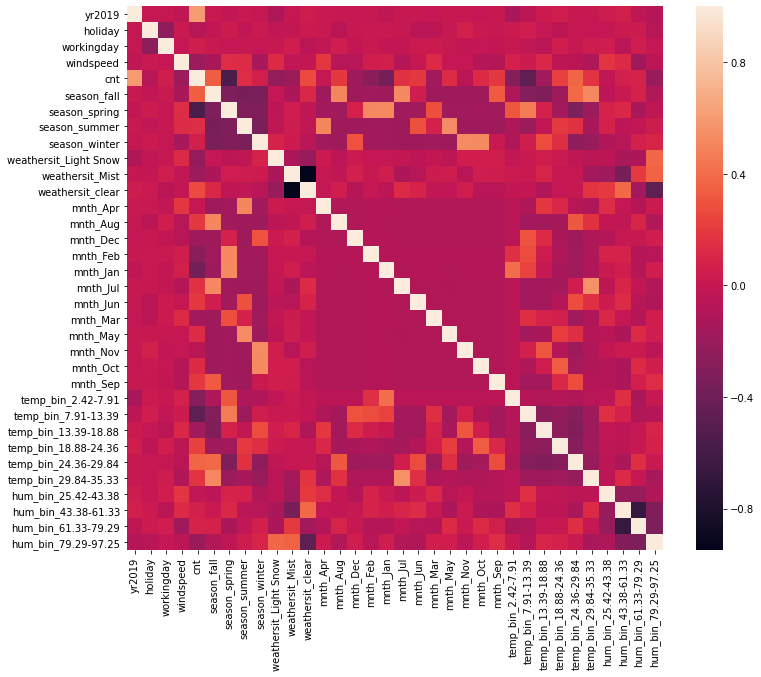

In [426]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr())

## Splitting the Data into Training and Testing Sets

In [427]:
np.random.seed(0)
# We specify this so that the train and test data set always have the same rows, respectively
df_train, df_test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state = 100)

In [428]:
df_train.columns

Index(['yr2019', 'holiday', 'workingday', 'windspeed', 'cnt', 'season_fall',
       'season_spring', 'season_summer', 'season_winter',
       'weathersit_Light Snow', 'weathersit_Mist', 'weathersit_clear',
       'mnth_Apr', 'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul',
       'mnth_Jun', 'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep',
       'temp_bin_2.42-7.91', 'temp_bin_7.91-13.39', 'temp_bin_13.39-18.88',
       'temp_bin_18.88-24.36', 'temp_bin_24.36-29.84', 'temp_bin_29.84-35.33',
       'hum_bin_25.42-43.38', 'hum_bin_43.38-61.33', 'hum_bin_61.33-79.29',
       'hum_bin_79.29-97.25'],
      dtype='object')

In [429]:
df_train.head()

,yr2019,holiday,workingday,windspeed,cnt,season_fall,season_spring,season_summer,season_winter,weathersit_Light Snow,...,temp_bin_2.42-7.91,temp_bin_7.91-13.39,temp_bin_13.39-18.88,temp_bin_18.88-24.36,temp_bin_24.36-29.84,temp_bin_29.84-35.33,hum_bin_25.42-43.38,hum_bin_43.38-61.33,hum_bin_61.33-79.29,hum_bin_79.29-97.25
495,1,0,1,15.874779,7030,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
537,1,0,1,12.250414,5823,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
703,1,0,1,21.709407,5729,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
231,0,0,0,6.999289,5191,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
435,1,0,1,13.916771,5298,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


## Rescaling the windspeed and cnt features

In [430]:
scaler = MinMaxScaler()

In [431]:
# Apply scaler() to continous variables
num_vars = ['windspeed','cnt']

df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

df_train.head()

,yr2019,holiday,workingday,windspeed,cnt,season_fall,season_spring,season_summer,season_winter,weathersit_Light Snow,...,temp_bin_2.42-7.91,temp_bin_7.91-13.39,temp_bin_13.39-18.88,temp_bin_18.88-24.36,temp_bin_24.36-29.84,temp_bin_29.84-35.33,hum_bin_25.42-43.38,hum_bin_43.38-61.33,hum_bin_61.33-79.29,hum_bin_79.29-97.25
495,1,0,1,0.581746,0.839247,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
537,1,0,1,0.420059,0.685743,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
703,1,0,1,0.842035,0.673789,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
231,0,0,0,0.185801,0.605367,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
435,1,0,1,0.494397,0.618975,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [432]:
df_train.describe()

,yr2019,holiday,workingday,windspeed,cnt,season_fall,season_spring,season_summer,season_winter,weathersit_Light Snow,...,temp_bin_2.42-7.91,temp_bin_7.91-13.39,temp_bin_13.39-18.88,temp_bin_18.88-24.36,temp_bin_24.36-29.84,temp_bin_29.84-35.33,hum_bin_25.42-43.38,hum_bin_43.38-61.33,hum_bin_61.33-79.29,hum_bin_79.29-97.25
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,...,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,0.506098,0.026423,0.697154,0.415621,0.524610,0.274390,0.237805,0.237805,0.250000,0.024390,...,0.028455,0.195122,0.227642,0.178862,0.256098,0.113821,0.063008,0.378049,0.410569,0.146341
std,0.500472,0.160552,0.459957,0.206919,0.243302,0.446661,0.426172,0.426172,0.433453,0.154414,...,0.166439,0.396698,0.419737,0.383627,0.436921,0.317917,0.243225,0.485393,0.492438,0.353808
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.271370,0.350025,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.391259,0.528806,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.546916,0.713532,1.000000,0.000000,0.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###  Dividing into X and Y sets for the model building

In [433]:
y_train = df_train.pop('cnt')
X_train = df_train

# Building model using Recursive feature elimination RFE

In [434]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [435]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr2019', True, 1),
 ('holiday', True, 1),
 ('workingday', False, 19),
 ('windspeed', False, 17),
 ('season_fall', False, 16),
 ('season_spring', True, 1),
 ('season_summer', False, 18),
 ('season_winter', False, 8),
 ('weathersit_Light Snow', True, 1),
 ('weathersit_Mist', False, 9),
 ('weathersit_clear', True, 1),
 ('mnth_Apr', False, 13),
 ('mnth_Aug', False, 5),
 ('mnth_Dec', False, 14),
 ('mnth_Feb', False, 11),
 ('mnth_Jan', False, 2),
 ('mnth_Jul', False, 4),
 ('mnth_Jun', False, 6),
 ('mnth_Mar', False, 15),
 ('mnth_May', False, 7),
 ('mnth_Nov', False, 12),
 ('mnth_Oct', True, 1),
 ('mnth_Sep', False, 3),
 ('temp_bin_2.42-7.91', True, 1),
 ('temp_bin_7.91-13.39', True, 1),
 ('temp_bin_13.39-18.88', False, 10),
 ('temp_bin_18.88-24.36', True, 1),
 ('temp_bin_24.36-29.84', True, 1),
 ('temp_bin_29.84-35.33', True, 1),
 ('hum_bin_25.42-43.38', True, 1),
 ('hum_bin_43.38-61.33', True, 1),
 ('hum_bin_61.33-79.29', True, 1),
 ('hum_bin_79.29-97.25', True, 1)]

In [436]:
# printing the columns supported by RFE
col = X_train.columns[rfe.support_]
col

Index(['yr2019', 'holiday', 'season_spring', 'weathersit_Light Snow',
       'weathersit_clear', 'mnth_Oct', 'temp_bin_2.42-7.91',
       'temp_bin_7.91-13.39', 'temp_bin_18.88-24.36', 'temp_bin_24.36-29.84',
       'temp_bin_29.84-35.33', 'hum_bin_25.42-43.38', 'hum_bin_43.38-61.33',
       'hum_bin_61.33-79.29', 'hum_bin_79.29-97.25'],
      dtype='object')

In [437]:
# printing the columns not supported by RFE
X_train.columns[~rfe.support_]

Index(['workingday', 'windspeed', 'season_fall', 'season_summer',
       'season_winter', 'weathersit_Mist', 'mnth_Apr', 'mnth_Aug', 'mnth_Dec',
       'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun', 'mnth_Mar', 'mnth_May',
       'mnth_Nov', 'mnth_Sep', 'temp_bin_13.39-18.88'],
      dtype='object')

# Building model using statsmodel, for the detailed statistics

In [438]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [439]:
# Adding a constant variable
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit()

In [440]:
# summary of the linear model
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     194.4
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          6.65e-192
Time:                        02:22:41   Log-Likelihood:                 480.87
No. Observations:                 492   AIC:                            -929.7
Df Residuals:                     476   BIC:                            -862.6
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.48

#### p-value for hum_bin_43.38-61.33 is greater than 0.05 . Hence we are not considering the column

In [441]:
# Dropping the column hum_bin_43.38-61.33 and checking the model
X_train_rfe = X_train_rfe.drop(["hum_bin_43.38-61.33"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     207.5
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          1.51e-192
Time:                        02:22:41   Log-Likelihood:                 479.62
No. Observations:                 492   AIC:                            -929.2
Df Residuals:                     477   BIC:                            -866.3
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.33

#### p-value for hum_bin_25.42-43.38 is greater than 0.05 . Hence we are not considering the column

In [442]:
# Dropping the hum_bin_25.42-43.38 column and checking the model
X_train_rfe = X_train_rfe.drop(["hum_bin_25.42-43.38"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.855
Method:                 Least Squares   F-statistic:                     223.3
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          1.68e-193
Time:                        02:22:41   Log-Likelihood:                 479.08
No. Observations:                 492   AIC:                            -930.2
Df Residuals:                     478   BIC:                            -871.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.33

#### p-value for hum_bin_61.33-79.29 is greater than 0.05 . Hence we are not considering the column

In [443]:
# Dropping the hum_bin_61.33-79.29 column and checking the model
X_train_rfe = X_train_rfe.drop(["hum_bin_61.33-79.29"], axis = 1)
X_train_lm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train,X_train_lm).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     241.1
Date:                Mon, 02 Nov 2020   Prob (F-statistic):          3.37e-194
Time:                        02:22:41   Log-Likelihood:                 477.88
No. Observations:                 492   AIC:                            -929.8
Df Residuals:                     479   BIC:                            -875.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.32

In [444]:
# Checking the VIF values
printVIF(X_train_rfe.columns,X_train)

                 Features   VIF
4        weathersit_clear  2.70
2           season_spring  1.95
0                  yr2019  1.87
7     temp_bin_7.91-13.39  1.71
9    temp_bin_24.36-29.84  1.70
8    temp_bin_18.88-24.36  1.69
11    hum_bin_79.29-97.25  1.50
10   temp_bin_29.84-35.33  1.40
5                mnth_Oct  1.30
6      temp_bin_2.42-7.91  1.24
3   weathersit_Light Snow  1.22
1                 holiday  1.04


#### VIF for columns considered in the model is less than 5. Hence we predict the data using the above model.

<AxesSubplot:>

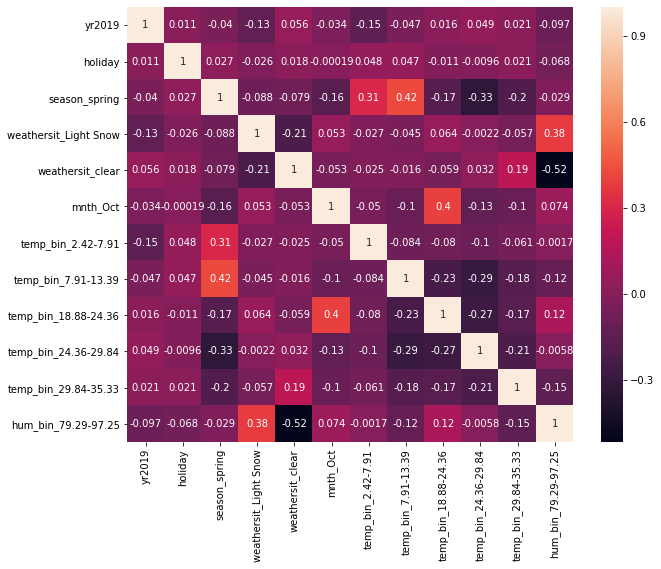

In [445]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_rfe.corr(), annot=True)

In [446]:
X_train_rfe.columns

Index(['yr2019', 'holiday', 'season_spring', 'weathersit_Light Snow',
       'weathersit_clear', 'mnth_Oct', 'temp_bin_2.42-7.91',
       'temp_bin_7.91-13.39', 'temp_bin_18.88-24.36', 'temp_bin_24.36-29.84',
       'temp_bin_29.84-35.33', 'hum_bin_79.29-97.25'],
      dtype='object')

### Residual Analysis of the train data

In [447]:
# Predict the y_train using the model
y_train_pred = lm.predict(X_train_lm)

Text(0, 0.5, 'y_train_pred')

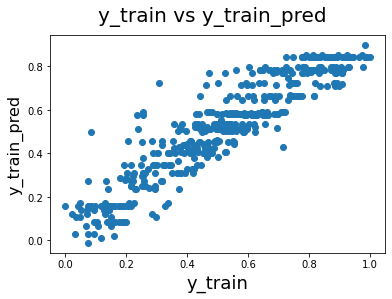

In [448]:
fig = plt.figure()
plt.scatter(y_train,y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize=20)             
plt.xlabel('y_train', fontsize=18)                        
plt.ylabel('y_train_pred', fontsize=16)

Text(0.5, 0, 'Errors')

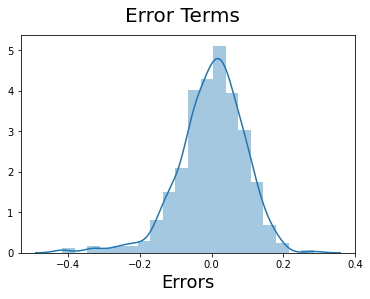

In [449]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_pred), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                 
plt.xlabel('Errors', fontsize = 18)   

## Making Predictions

####  Applying the scaling on the test sets

In [450]:
num_vars = ['windspeed','cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Dividing into X_test and y_test

In [451]:
y_test = df_test.pop('cnt')

In [452]:

X_test = df_test[X_train_rfe.columns]
# Adding constant variable to test dataframe
X_test_sm = sm.add_constant(X_test)
# Making predictions using the model
y_test_pred = lm.predict(X_test_sm)

Text(0, 0.5, 'y_test_pred')

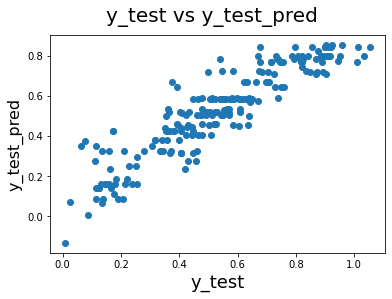

In [453]:
# Plotting y_test and y_test_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)

### Test data residual analysis

<AxesSubplot:>

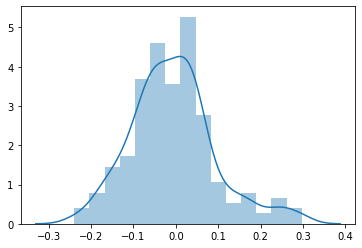

In [454]:
sns.distplot(y_test_pred-y_test)

###  Errors are distributed widely around zero(mean is appromoximately around zero)

<AxesSubplot:xlabel='residual_zscore'>

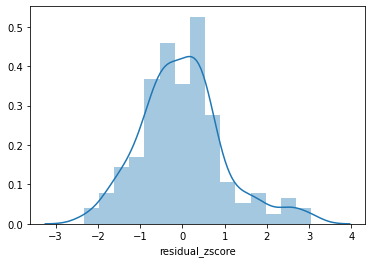

In [455]:
output=pd.DataFrame()
output['residual']= y_test_pred-y_test
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
col=['residual']
output['residual_zscore']=scaler.fit_transform(output[col])
sns.distplot(output['residual_zscore'])

### Errors are normally distributed . Data is within -3 to 3 z score.

Text(0, 0.5, 'y_test')

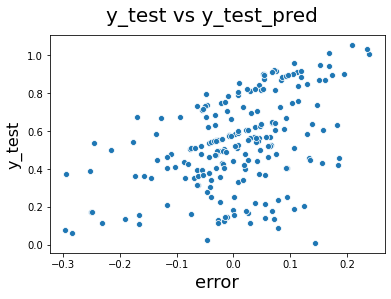

In [456]:
# Checking if residuals are having equal variance or not
fig = plt.figure()
sns.scatterplot(y_test-y_test_pred,y_test)
fig.suptitle('y_test vs y_test_pred', fontsize=20)              
plt.xlabel('error', fontsize=18) 
plt.ylabel('y_test', fontsize=16)

#### Errors are doesn't follow any pattern(equal variance) around mean.

In [457]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)

0.8307818020372161

In [458]:
from sklearn.metrics import r2_score
r2_score(y_train, y_train_pred)

0.8579440464969347

In [459]:
round((r2_score(y_train, y_train_pred)-r2_score(y_test, y_test_pred))*100,2)

2.72

#### Difference in r score for train and test is 2.72 which is less 5. Hence the model can be considered as best fit.

In [460]:
lm.params

const                    0.325929
yr2019                   0.264099
holiday                 -0.075604
season_spring           -0.152674
weathersit_Light Snow   -0.164421
weathersit_clear         0.076160
mnth_Oct                 0.053643
temp_bin_2.42-7.91      -0.108214
temp_bin_7.91-13.39     -0.090328
temp_bin_18.88-24.36     0.131690
temp_bin_24.36-29.84     0.178877
temp_bin_29.84-35.33     0.118629
hum_bin_79.29-97.25     -0.052828
dtype: float64

### Equation for the best fitted line is

cnt= 0.325929+ 0.264099x yr2019-0.075604x holiday -0.152674 x season_spring -0.164421 x weathersit_Light Snow+0.076160 x weathersit_clear+0.053643xmnth_Oct-0.108214x(temp_bin_2.42-7.91)-0.090328x(temp_bin_7.91-13.39)+0.131690x(temp_bin_18.88-24.36)+0.178877x(temp_bin_24.36-29.84)+0.118629x(temp_bin_29.84-35.33)-0.052828x(hum_bin_79.29-97.25)

### We could have improvized the model by considering non linear model for temperature 